## Bibliotecas

In [1]:
import os
import re
import pickle
import statistics
import numpy as np
import pandas as pd
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [2]:
# Importar los modelos de clasificación
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

## Cargar información

In [3]:
with open("../normalizacion_texto/lista_contenido_normalizado.pkl", "rb") as f:
    corpus = pickle.load(f)

In [4]:
data = pd.read_excel('../apoyo/Rest_Mex_2022.xlsx')
y = data['Polarity'].values

## Train y test

In [5]:
x_train, x_test, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=0)

## Representación de texto

In [6]:
# --> Vector Binario
# vectorizador_binario = CountVectorizer(binary=True, token_pattern=r'(?u)\w\w+|\w\w+\n|\.')

# X_train_vector = vectorizador_binario.fit_transform(x_train)
# X_test_vector = vectorizador_binario.transform(x_test)

# --> Vector frecuencia
vectorizador_frecuencia = CountVectorizer(token_pattern=r'(?u)\w\w+|\w\w+\n|\.')

X_train_vector = vectorizador_frecuencia.fit_transform(x_train)
X_test_vector = vectorizador_frecuencia.transform(x_test)

# --> Vector tf-idf
# vectorizador_tfidf = TfidfVectorizer(token_pattern=r'(?u)\w\w+|\w\w+\n|\.')

# X_train_vector = vectorizador_tfidf.fit_transform(x_train)
# X_test_vector = vectorizador_tfidf.transform(x_test)

In [7]:
print(X_train_vector[0].shape)

(1, 37452)


## Polaridades

In [8]:
def load_sel():
	"""
	Función que carga el diccionario de polaridades de SEL
	"""
	lexicon_sel = {}
	input_file = open('../apoyo/SEL_full.txt', 'r')

	# Para cada línea del archivo
	for line in input_file:
		#Las líneas del lexicon tienen el siguiente formato:
		#abundancia	0	0	50	50	0.83	Alegría
		
		palabras = line.split("\t")					# Esto hara que se separe la linea en una lista de palabras
		palabras[6]= re.sub('\n', '', palabras[6])	# Esto hara que se elimine el salto de linea
		pair = (palabras[6], palabras[5])			# Esto hara que se guarde la palabra y su valor de polaridad

		if lexicon_sel:								# Si el diccionario no esta vacio
			if palabras[0] not in lexicon_sel:		# Si la palabra no esta en el diccionario
				lista = [pair]						# Se crea una lista con la palabra y su valor de polaridad
				lexicon_sel[palabras[0]] = lista	# Se agrega la lista al diccionario
			else:
				lexicon_sel[palabras[0]].append (pair)	# Si la palabra ya esta en el diccionario, se agrega la palabra y su valor de polaridad a la lista
		else:										# Si el diccionario esta vacio
			lista = [pair]							# Se crea una lista con la palabra y su valor de polaridad
			lexicon_sel[palabras[0]] = lista		# Se agrega la lista al diccionario

	input_file.close()								# Se cierra el archivo
	del lexicon_sel['Palabra']; #Esta llave se inserta porque es parte del encabezado del diccionario, por lo que se requiere eliminar
	#Estructura resultante
		#'hastiar': [('Enojo\n', '0.629'), ('Repulsi\xf3n\n', '0.596')]
	return lexicon_sel								# Se regresa el diccionario

def getSELFeatures(cadenas, lexicon_sel):
	"""
	Función que obtiene las características de SEL
	"""
	#'hastiar': [('Enojo\n', '0.629'), ('Repulsi\xf3n\n', '0.596')]
	features = []
	for cadena in cadenas:
		valor_alegria = 0.0
		valor_enojo = 0.0
		valor_miedo = 0.0
		valor_repulsion = 0.0
		valor_sorpresa = 0.0
		valor_tristeza = 0.0
		cadena_palabras = re.split('\s+', cadena)
		dic = {}
		for palabra in cadena_palabras:
			if palabra in lexicon_sel:
				caracteristicas = lexicon_sel[palabra]
				for emocion, valor in caracteristicas:
					if emocion == 'Alegría':
						valor_alegria = valor_alegria + float(valor)
					elif emocion == 'Tristeza':
						valor_tristeza = valor_tristeza + float(valor)
					elif emocion == 'Enojo':
						valor_enojo = valor_enojo + float(valor)
					elif emocion == 'Repulsión':
						valor_repulsion = valor_repulsion + float(valor)
					elif emocion == 'Miedo':
						valor_miedo = valor_miedo + float(valor)
					elif emocion == 'Sorpresa':
						valor_sorpresa = valor_sorpresa + float(valor)
		dic['__alegria__'] = valor_alegria
		dic['__tristeza__'] = valor_tristeza
		dic['__enojo__'] = valor_enojo
		dic['__repulsion__'] = valor_repulsion
		dic['__miedo__'] = valor_miedo
		dic['__sorpresa__'] = valor_sorpresa
		
		#Esto es para los valores acumulados del mapeo a positivo (alegría + sorpresa) y negativo (enojo + miedo + repulsión + tristeza)
		dic['acumuladopositivo'] = dic['__alegria__'] + dic['__sorpresa__']
		dic['acumuladonegative'] = dic['__enojo__'] + dic['__miedo__'] + dic['__repulsion__'] + dic['__tristeza__']
		
		features.append (dic)
	return features

In [9]:
if (os.path.exists('lexicon_sel.pkl')):
		lexicon_sel_file = open ('lexicon_sel.pkl','rb')
		lexicon_sel = pickle.load(lexicon_sel_file)
else:
	lexicon_sel = load_sel()
	lexicon_sel_file = open ('lexicon_sel.pkl','wb')
	pickle.dump(lexicon_sel, lexicon_sel_file)
	lexicon_sel_file.close()

In [10]:
# --> crear polaridades
polaridades_train = getSELFeatures(x_train, lexicon_sel)
polaridades_test = getSELFeatures(x_test, lexicon_sel)

In [11]:
def polaridad_cadenas(polaridades):
    """
    Esta función regresa un arreglo con los valores de polaridad de cada cadena
    """

    polaridad_cadenas = []
    for x in range(len(polaridades)):
        polaridad_cadena_pos = np.array([polaridades[x]['acumuladopositivo']])
        polaridad_cadena_neg = np.array([polaridades[x]['acumuladonegative']])
        polaridad_cadena = np.concatenate((polaridad_cadena_pos, polaridad_cadena_neg), axis=0)
        polaridad_cadenas.append(polaridad_cadena)
    return polaridad_cadenas

In [12]:
polaridad_cadenas_train = polaridad_cadenas(polaridades_train)
polaridad_cadenas_test = polaridad_cadenas(polaridades_test)

print(polaridad_cadenas_train[0])

[0.892 1.754]


In [13]:
matriz_polaridades_train = csr_matrix(polaridad_cadenas_train)
matriz_polaridades_test = csr_matrix(polaridad_cadenas_test)
print(matriz_polaridades_train[0])

  (0, 0)	0.8920000000000001
  (0, 1)	1.754


In [14]:
# --> Concatear vectores con polaridades
X_train_vector = hstack((X_train_vector, matriz_polaridades_train))
X_test_vector = hstack((X_test_vector, matriz_polaridades_test))

print(X_train_vector[0].shape)

(1, 37454)


## KFold Cross Validation

In [15]:
clf = MultinomialNB(alpha=0.1, fit_prior=True)
# clf = LogisticRegression(solver='lbfgs', max_iter=2000, C=1.0, penalty='l2')
# clf = LogisticRegression(solver='lbfgs', max_iter=2000)
# clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
# clf = KNeighborsClassifier(n_neighbors=3)
# clf = MLPClassifier(hidden_layer_sizes=(50, 25), activation='relu', solver='adam', alpha=0.0001, learning_rate='constant', max_iter=200, batch_size='auto', early_stopping=False)

# clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1.0)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
f1_macro = []

In [16]:
# --> Iteraciones
for entrenamiento, prueba in skf.split(X_train_vector, y_train):
    # --> Validacion cruzada
    rasgos_entrenamiento = X_train_vector[entrenamiento]
    rasgos_prueba = X_train_vector[prueba]

    clases_entrenamiento = y_train[entrenamiento]
    clases_prueba = y_train[prueba]

    # --> Entrenamiento
    clf.fit(rasgos_entrenamiento, clases_entrenamiento)
    clase_predicha = clf.predict(rasgos_prueba)

    # --> Métrica de rendimiento
    f1_macro.append(f1_score(clases_prueba, clase_predicha, average='macro'))

    # --> Porcentaje avanzado
    print(f"\rProgreso: {len(f1_macro)/skf.get_n_splits():.1%}", end="")

Progreso: 100.0%

## Evaluar rendimiento

In [55]:
# --> Average F1 score
print(f"F1 macro: {round(statistics.mean(f1_macro), 2)*100}%")

# --> Guardar resultados en txt uno sobre otro
# with open("resultados.txt", "a") as f:
#     f.write(f"LogisticRegression: {round(statistics.mean(f1_macro), 2)*100} %\n")

F1 macro: 44.0%


In [56]:
# --> Classification report
from sklearn.metrics import classification_report

print(classification_report(clases_prueba, clase_predicha))

# --> Guardar reporte en txt uno sobre otro
with open("reportes/Binario/MLPClassifier-rasgos.txt", "a") as f:
    f.write(f"{classification_report(clases_prueba, clase_predicha)}\n")

              precision    recall  f1-score   support

           1       0.39      0.40      0.40        88
           2       0.33      0.26      0.29       117
           3       0.35      0.44      0.39       340
           4       0.38      0.49      0.43       943
           5       0.88      0.79      0.83      3345

    accuracy                           0.69      4833
   macro avg       0.47      0.47      0.47      4833
weighted avg       0.72      0.69      0.70      4833



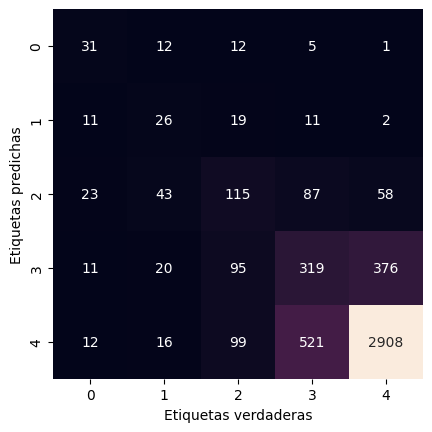

In [46]:
# --> Matriz de confusión
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

mat = confusion_matrix(clases_prueba, clase_predicha)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Etiquetas verdaderas')
plt.ylabel('Etiquetas predichas')
plt.show()
